#### CANB8347 Machine Learning Project
Given annotated dataset, develop a supervised machine learning method to predict live births from multi-dimensional data

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

# sklearn tools
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline

---
#### 0. read in dataset and look at feature labels

In [4]:
vlbw = pd.read_csv('data/vlbw_train.csv')

In [5]:
vlbw.drop('Unnamed: 0', axis=1, inplace=True) # get rid of index axis
vlbw.columns

Index(['birth', 'exit', 'hospstay', 'lowph', 'pltct', 'race', 'bwt', 'gest',
       'inout', 'twn', 'lol', 'magsulf', 'meth', 'toc', 'delivery', 'apg1',
       'vent', 'pneumo', 'pda', 'cld', 'pvh', 'ivh', 'ipe', 'year', 'sex',
       'dead'],
      dtype='object')

---
#### 1. devise scheme for numerizing categorical data

In [6]:
def numerize(df, col, drop=True):
    '''
    make categorical data numeric from 0 - n categories
        df = dataframe
        col = column to numerize into n_categories columns
        drop = drop original column or retain in df?
    '''
    temp = df.copy(deep=True) # copy df so you don't affect it
    
    for cat in temp[col][temp[col].notnull()].unique():
        # for each categorical value, create a new column with binary values for T/F
        temp[col+'_'+cat] = (temp[col]==cat)*1
        
    if drop:
        return temp.drop(col, axis=1)
    
    else:
        return temp

In [7]:
# perform numerization on whole dataset
for feature, datatype in zip(vlbw.dtypes.index, vlbw.dtypes):
    if datatype == 'object':
        vlbw = numerize(vlbw, feature)

In [8]:
# look at resulting features
# should be more than we started with, as data is now in long-form
vlbw.columns

Index(['birth', 'exit', 'hospstay', 'lowph', 'pltct', 'bwt', 'gest', 'twn',
       'lol', 'magsulf', 'meth', 'toc', 'apg1', 'vent', 'pneumo', 'pda', 'cld',
       'year', 'dead', 'race_white', 'race_black', 'race_native American',
       'race_oriental', 'inout_born at Duke', 'inout_transported',
       'delivery_abdominal', 'delivery_vaginal', 'pvh_definite', 'pvh_absent',
       'pvh_possible', 'ivh_definite', 'ivh_absent', 'ivh_possible',
       'ipe_absent', 'ipe_definite', 'ipe_possible', 'sex_female', 'sex_male'],
      dtype='object')

In [9]:
# save the 'numerified' data as .csv file
vlbw.to_csv('data/vlbw_train_numeric.csv', index=False)

---
#### 2. impute missing values with mode of each feature
might not be the best strategy for dealing with `NaN`s, but let's just see how a PCA looks 

In [10]:
# fill NaNs with mode value of each column
vlbw_filled = SimpleImputer(strategy='most_frequent').fit_transform(vlbw)

In [11]:
# normalize each column to fractional representation between 0 and 1
vlbw_filled_norm = normalize(vlbw_filled, axis=1, norm='l1')

---
#### 3. look at principal components and see where highest explained variance lies

In [13]:
# perform principal component analysis on entire imputed dataset
vlbw_PCA_fit = PCA(n_components=5).fit(vlbw_filled_norm)
vlbw_PCA = vlbw_PCA_fit.transform(vlbw_filled_norm)

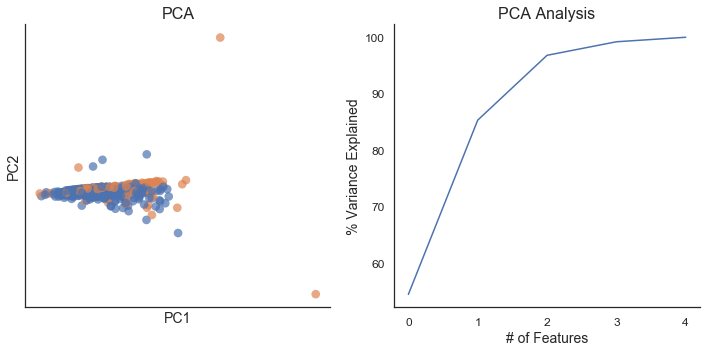

In [14]:
# plot PCA results for first two PCs, colored by desired label (live birth)
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x=vlbw_PCA[:,0], y=vlbw_PCA[:,1], s=75, alpha=0.7, hue=vlbw['dead'], legend=None, edgecolor='none')
plt.tick_params(labelbottom=False, labelleft=False)
plt.ylabel('PC2', fontsize=14)
plt.xlabel('PC1', fontsize=14)
plt.title('PCA', fontsize=16)

plt.subplot(122)
plt.plot(np.cumsum(np.round(vlbw_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.tick_params(labelsize=12)
plt.ylabel('% Variance Explained', fontsize=14)
plt.xlabel('# of Features', fontsize=14)
plt.title('PCA Analysis', fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()

In [15]:
# we can extract the contribution of each feature to each PC
PCfeatures = pd.DataFrame(vlbw_PCA_fit.components_, columns=vlbw.columns)
# look at top 10 features that contribute to PC1, in descending order
PCfeatures.iloc[0,:].rank().sort_values()

bwt                      1.0
delivery_abdominal       2.0
race_white               3.0
twn                      4.0
meth                     5.0
race_native American     6.0
ipe_possible             7.0
race_oriental            8.0
magsulf                  9.0
toc                     10.0
ivh_possible            11.0
inout_transported       12.0
pvh_possible            13.0
ipe_definite            14.0
sex_female              15.0
pvh_definite            16.0
ivh_definite            17.0
pneumo                  18.0
sex_male                19.0
pvh_absent              20.0
ivh_absent              21.0
pda                     22.0
inout_born at Duke      23.0
ipe_absent              24.0
race_black              25.0
delivery_vaginal        26.0
cld                     27.0
dead                    28.0
apg1                    29.0
vent                    30.0
lowph                   31.0
gest                    32.0
lol                     33.0
exit                    34.0
birth         

Looks like birthweight and abdominal delivery are the two largest contributors to live birth from this dataset.  

---
Next steps to try:
* eliminate 'noisy' features with low contributions to first few PCs
* think about other ways to eliminate or impute `NaN` values - this was just a first-pass
* start researching [supervised approaches](https://scikit-learn.org/stable/supervised_learning.html) to start fitting to this dataset 